## What is this notebook for?

This is my first foray into machine learning (apart from when I trained a useless model on customer feedback last year).

As appears to be tradition, I'll be attempting the Titanic prediction compeition, hosted on Kaggle https://www.kaggle.com/c/titanic

From the blurb:

_The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history._

_On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew._

_While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others._

_In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc)_

I'm going to split into a number of sections:

- Get Data
- EDA
- Feature engineering
- Modelling
- Results


tl;dr

<img src="files/ralph.png">



## Preparations

### Prepare the environment

Let's get my most commonly used libraries ready. These are the go to for maths, data wrangling, and plotting

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [417]:
path=r'/Users/afindlay/documents/exports/'
import time
import datetime

Ok, now lets import the libraries that will do all of the actual ~~magic~~ machine learning for us.

In [2]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, classification_report, accuracy_score

 ### Get Data

Now we need to import the data. I've downloaded the data into the current working directory for this repo on my local machine, which sits in it's own folder called `titanic`.

In [3]:
import os
path = os.getcwd()+'/titanic/'

In [4]:
os.getcwd()

'/Users/afindlay/Documents/repos/elc-ml'

In [5]:
test = pd.read_csv(path+'test.csv')
train = pd.read_csv(path+'train.csv')

In [6]:
test.shape

(418, 11)

In [7]:
train.shape

(891, 12)

I'm also going to convert the column names to lower case

In [8]:
test.columns = test.columns.str.lower()
train.columns = train.columns.str.lower()

Ok now we have two pandas dataframes called `test` and `train`. We're not going to touch test until we start to do some modelling, so let's proceed to some EDA on `train`.

## EDA

These are the descriptions of what each column in the dataframe means:

|  Variable | Definition | Key |
| :--- | :--- | :--- |
|  survived | Survival | 0 = No, 1 = Yes |
|  pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
|  sex | Sex |  |
|  Age | Age in years |  |
|  sibsp | # of siblings / spouses aboard the Titanic |  |
|  parch | # of parents / children aboard the Titanic |  |
|  ticket | Ticket number |  |
|  fare | Passenger fare |  |
|  cabin | Cabin number |  |
|  embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

### How clean is the data?

The first thing I want to know is how clean this data is. Is there missing data?

In [9]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [10]:
train.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [463]:
test.describe()

,passengerid,pclass,age,sibsp,parch,fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [11]:
train.loc[train.survived==1,:].describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,342.000000,342.0,342.000000,290.000000,342.000000,342.000000,342.000000
mean,444.368421,1.0,1.950292,28.343690,0.473684,0.464912,48.395408
std,252.358840,0.0,0.863321,14.950952,0.708688,0.771712,66.596998
min,2.000000,1.0,1.000000,0.420000,0.000000,0.000000,0.000000
25%,250.750000,1.0,1.000000,19.000000,0.000000,0.000000,12.475000
50%,439.500000,1.0,2.000000,28.000000,0.000000,0.000000,26.000000
75%,651.500000,1.0,3.000000,36.000000,1.000000,1.000000,57.000000
max,890.000000,1.0,3.000000,80.000000,4.000000,5.000000,512.329200


We have 12 columns here, but only 7 are represented in `pd.describe` as they are categorical variables. We're going to need to ohe these

In [12]:
train.count()

passengerid    891
survived       891
pclass         891
name           891
sex            891
age            714
sibsp          891
parch          891
ticket         891
fare           891
cabin          204
embarked       889
dtype: int64

In [310]:
test.count()

passengerid    418
pclass         418
name           418
sex            418
age            332
sibsp          418
parch          418
ticket         418
fare           417
cabin           91
embarked       418
pclass1        418
sibsp1         418
parch1         418
dtype: int64

There are missing rows in age, cabin, and embarked, and one row missing for fare in test

In [13]:
train.age.isna().value_counts(normalize=True)

False    0.801347
True     0.198653
Name: age, dtype: float64

In [14]:
train.cabin.isna().value_counts(normalize=True)

True     0.771044
False    0.228956
Name: cabin, dtype: float64

In [15]:
train.embarked.isna().value_counts(normalize=True)

False    0.997755
True     0.002245
Name: embarked, dtype: float64

Let's take a look at the actual data

In [16]:
train.sample(n=15)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
101,102,0,3,"Petroff, Mr. Pastcho (""Pentcho"")",male,NaN,0,0,349215,7.8958,NaN,S
802,803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0000,B96 B98,S
654,655,0,3,"Hegarty, Miss. Hanora ""Nora""",female,18.0,0,0,365226,6.7500,NaN,Q
721,722,0,3,"Jensen, Mr. Svend Lauritz",male,17.0,1,0,350048,7.0542,NaN,S
66,67,1,2,"Nye, Mrs. (Elizabeth Ramell)",female,29.0,0,0,C.A. 29395,10.5000,F33,S
782,783,0,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.0000,D6,S
254,255,0,3,"Rosblom, Mrs. Viktor (Helena Wilhelmina)",female,41.0,0,2,370129,20.2125,NaN,S
657,658,0,3,"Bourke, Mrs. John (Catherine)",female,32.0,1,1,364849,15.5000,NaN,Q
350,351,0,3,"Odahl, Mr. Nils Martin",male,23.0,0,0,7267,9.2250,NaN,S
106,107,1,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0,0,0,343120,7.6500,NaN,S


In [166]:
train3.head()

,survived,fare,sex_male,embarked_Q,embarked_S,pclass1_2,pclass1_3,sibsp1_1,sibsp1_2,sibsp1_3,...,sibsp1_8,parch1_1,parch1_2,parch1_3,parch1_4,parch1_5,parch1_6,age_fillmean,age_fillmode,age_fillmedian
0,0,7.2500,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,22.0,22.0,22.0
1,1,71.2833,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,38.0,38.0,38.0
2,1,7.9250,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,26.0,26.0,26.0
3,1,53.1000,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,35.0,35.0,35.0
4,0,8.0500,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,35.0,35.0,35.0


In [17]:
train.dtypes

passengerid      int64
survived         int64
pclass           int64
name            object
sex             object
age            float64
sibsp            int64
parch            int64
ticket          object
fare           float64
cabin           object
embarked        object
dtype: object

Observations:

- Name is going to be pretty useless, as is ticket. The only things it could signify are price, or class - which we already have and will be correlated.
- Cabin is missing most of it's data, but I imagine for the records we have they'll strongly correlate to class or fare so can likely safely drop this column.
- We have `nulls` in age but can probably fill with the median. The missing data in embarked probably doesn't matter. Can leave in or drop, it's only 2 records.
- pClass, Sex & embarked need to be encoded
- We might have some outliers for price that need taking care of


### Cleaning/encoding

#### Encoding

We can do one hot encoding with `pd.get_dummies()` - `drop_first=True` get's rid of n-1 dummies so we don't have perfectly correlated data e.g. `is_male`, `is_female`

In [18]:
train[['pclass','sex','embarked']]

,pclass,sex,embarked
0,3,male,S
1,1,female,C
2,3,female,S
3,1,female,S
4,3,male,S
...,...,...,...
886,2,male,S
887,1,female,S
888,3,female,S
889,1,male,C


In [19]:
train['pclass1'] = train['pclass'].astype(str)
train['sibsp1'] = train['sibsp'].astype(str)
train['parch1'] = train['parch'].astype(str)

In [20]:
test['pclass1'] = test['pclass'].astype(str)
test['sibsp1'] = test['sibsp'].astype(str)
test['parch1'] = test['parch'].astype(str)

In [21]:
pd.get_dummies(train[['sex','embarked','pclass1','sibsp1','parch1']],drop_first=True)

,sex_male,embarked_Q,embarked_S,pclass1_2,pclass1_3,sibsp1_1,sibsp1_2,sibsp1_3,sibsp1_4,sibsp1_5,sibsp1_8,parch1_1,parch1_2,parch1_3,parch1_4,parch1_5,parch1_6
0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
887,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
888,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0
889,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
train2 = pd.concat([train,pd.get_dummies(train[['sex','embarked','pclass1','sibsp1','parch1']],drop_first=True)],axis=1)

In [23]:
test2 = pd.concat([test,pd.get_dummies(test[['sex','embarked','pclass1','sibsp1','parch1']],drop_first=True)],axis=1)

In [24]:
train2.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked', 'pclass1', 'sibsp1',
       'parch1', 'sex_male', 'embarked_Q', 'embarked_S', 'pclass1_2',
       'pclass1_3', 'sibsp1_1', 'sibsp1_2', 'sibsp1_3', 'sibsp1_4', 'sibsp1_5',
       'sibsp1_8', 'parch1_1', 'parch1_2', 'parch1_3', 'parch1_4', 'parch1_5',
       'parch1_6'],
      dtype='object')

In [25]:
test2.columns

Index(['passengerid', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked', 'pclass1', 'sibsp1', 'parch1',
       'sex_male', 'embarked_Q', 'embarked_S', 'pclass1_2', 'pclass1_3',
       'sibsp1_1', 'sibsp1_2', 'sibsp1_3', 'sibsp1_4', 'sibsp1_5', 'sibsp1_8',
       'parch1_1', 'parch1_2', 'parch1_3', 'parch1_4', 'parch1_5', 'parch1_6',
       'parch1_9'],
      dtype='object')

In [26]:
train2.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,...,sibsp1_3,sibsp1_4,sibsp1_5,sibsp1_8,parch1_1,parch1_2,parch1_3,parch1_4,parch1_5,parch1_6
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,0,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,0,0,0


In [27]:
train2.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,...,sibsp1_3,sibsp1_4,sibsp1_5,sibsp1_8,parch1_1,parch1_2,parch1_3,parch1_4,parch1_5,parch1_6
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.647587,0.086420,0.722783,...,0.017957,0.020202,0.005612,0.007856,0.132435,0.089787,0.005612,0.004489,0.005612,0.001122
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990,0.281141,0.447876,...,0.132871,0.140770,0.074743,0.088337,0.339154,0.286037,0.074743,0.066890,0.074743,0.033501
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Maybe we need just a dummy variable for the presence of any siblings/parents

In [257]:
train2.loc[train2.sibsp>0,'sibsp_dummy'] = 1
test2.loc[train2.sibsp>0,'sibsp_dummy'] = 1
train2.sibsp_dummy.fillna(0,inplace=True)
test2.sibsp_dummy.fillna(0,inplace=True)

In [258]:
test2['sibsp_dummy']

0      1.0
1      1.0
2      0.0
3      1.0
4      0.0
      ... 
413    0.0
414    0.0
415    0.0
416    1.0
417    0.0
Name: sibsp_dummy, Length: 418, dtype: float64

In [259]:
test2['parch']

0      0
1      0
2      0
3      0
4      1
      ..
413    0
414    0
415    0
416    0
417    1
Name: parch, Length: 418, dtype: int64

In [261]:
train2.loc[train2.parch>0,'parch_dummy'] = 1
test2.loc[train2.parch>0,'parch_dummy'] = 1
train2.parch_dummy.fillna(0,inplace=True)
test2.parch_dummy.fillna(0,inplace=True)

#### Filling Nulls for age

I don't really know what the best thing to do is for age, so I'm going to create three new age columns, fillling the nulls with the mean, median and mode.

In [262]:
amean = train2.age.mean()
amode = train2.age.mode()
amed = train2.age.median()

In [263]:
amode

0    24.0
dtype: float64

In [264]:
train2.loc[train2.age.isnull(),'age_fillmean'] = amean
train2.loc[train2.age.isnull(),'age_fillmode'] = 24.0
train2.loc[train2.age.isnull(),'age_fillmedian'] = amed

In [265]:
train2.age_fillmean.fillna(train2.age,inplace=True)
train2.age_fillmode.fillna(train2.age,inplace=True)
train2.age_fillmedian.fillna(train2.age,inplace=True)

In [266]:
amean = test2.age.mean()
amode = test2.age.mode()
amed = test2.age.median()

In [267]:
amode

0    21.0
1    24.0
dtype: float64

In [268]:
test2.loc[test2.age.isnull(),'age_fillmean'] = amean
test2.loc[test2.age.isnull(),'age_fillmode'] = 24.0
test2.loc[test2.age.isnull(),'age_fillmedian'] = amed

In [269]:
test2.age_fillmean.fillna(test2.age,inplace=True)
test2.age_fillmode.fillna(test2.age,inplace=True)
test2.age_fillmedian.fillna(test2.age,inplace=True)

Given that this doesn't seem to make much difference apart from altering the median of age when using `fillmode`, I think we can just go with the mean, but I guess we can model with all three later?

In [270]:
train2.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,...,parch1_2,parch1_3,parch1_4,parch1_5,parch1_6,age_fillmean,age_fillmode,age_fillmedian,sibsp_dummy,parch_dummy
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.647587,0.086420,0.722783,...,0.089787,0.005612,0.004489,0.005612,0.001122,29.699118,28.566970,29.361582,0.317621,0.239057
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990,0.281141,0.447876,...,0.286037,0.074743,0.066890,0.074743,0.033501,13.002015,13.199572,13.019697,0.465813,0.426747
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.420000,0.420000,0.420000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,22.000000,22.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,29.699118,24.000000,28.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,35.000000,35.000000,35.000000,1.000000,0.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,80.000000,80.000000,80.000000,1.000000,1.000000


### Filling other nulls

In [322]:
train2.isnull().sum(axis = 0)

passengerid         0
survived            0
pclass              0
name                0
sex                 0
age               177
sibsp               0
parch               0
ticket              0
fare                0
cabin             687
embarked            2
pclass1             0
sibsp1              0
parch1              0
sex_male            0
embarked_Q          0
embarked_S          0
pclass1_2           0
pclass1_3           0
sibsp1_1            0
sibsp1_2            0
sibsp1_3            0
sibsp1_4            0
sibsp1_5            0
sibsp1_8            0
parch1_1            0
parch1_2            0
parch1_3            0
parch1_4            0
parch1_5            0
parch1_6            0
age_fillmean        0
age_fillmode        0
age_fillmedian      0
sibsp_dummy         0
parch_dummy         0
dtype: int64

In [323]:
test2.isnull().sum(axis = 0)

passengerid         0
pclass              0
name                0
sex                 0
age                86
sibsp               0
parch               0
ticket              0
fare                1
cabin             327
embarked            0
pclass1             0
sibsp1              0
parch1              0
sex_male            0
embarked_Q          0
embarked_S          0
pclass1_2           0
pclass1_3           0
sibsp1_1            0
sibsp1_2            0
sibsp1_3            0
sibsp1_4            0
sibsp1_5            0
sibsp1_8            0
parch1_1            0
parch1_2            0
parch1_3            0
parch1_4            0
parch1_5            0
parch1_6            0
parch1_9            0
age_fillmean        0
age_fillmode        0
age_fillmedian      0
sibsp_dummy         0
parch_dummy         0
dtype: int64

There is just the one in test

In [326]:
tfm = test2.fare.mean()

In [328]:
test2.loc[test2.fare.isna(),'fare'] = tfm

In [359]:
train3 = train2.loc[:,['survived','fare',\
                       'sex_male','embarked_Q', 'embarked_S', 'pclass1_2', 'pclass1_3',\
                       'sibsp_dummy','parch_dummy',\
                       'sibsp1_1', 'sibsp1_2', 'sibsp1_3', 'sibsp1_4', 'sibsp1_5', 'sibsp1_8',\
                       'parch1_1', 'parch1_2', 'parch1_3', 'parch1_4', 'parch1_5', 'parch1_6',\
                      \
                       'age_fillmean', #'age_fillmode', 'age_fillmedian'\
                      ]]

In [331]:
test2.columns

Index(['passengerid', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked', 'pclass1', 'sibsp1', 'parch1',
       'sex_male', 'embarked_Q', 'embarked_S', 'pclass1_2', 'pclass1_3',
       'sibsp1_1', 'sibsp1_2', 'sibsp1_3', 'sibsp1_4', 'sibsp1_5', 'sibsp1_8',
       'parch1_1', 'parch1_2', 'parch1_3', 'parch1_4', 'parch1_5', 'parch1_6',
       'parch1_9', 'age_fillmean', 'age_fillmode', 'age_fillmedian',
       'sibsp_dummy', 'parch_dummy'],
      dtype='object')

In [360]:
test3 = test2.loc[:,['fare',\
                       'sex_male','embarked_Q', 'embarked_S', 'pclass1_2', 'pclass1_3',\
                       'sibsp_dummy','parch_dummy',\
                      'sibsp1_1', 'sibsp1_2', 'sibsp1_3', 'sibsp1_4', 'sibsp1_5', 'sibsp1_8',\
                      'parch1_1', 'parch1_2', 'parch1_3', 'parch1_4', 'parch1_5', 'parch1_6',\
                      \
                       'age_fillmean', #'age_fillmode', 'age_fillmedian'\
                      ]]

In [333]:
path=r'/Users/afindlay/documents/exports/'

In [334]:
train3.to_csv(path+'train3.csv',index=False)
test3.to_csv(path+'test3.csv',index=False)

# Model

In [335]:
train3.columns

Index(['survived', 'fare', 'sex_male', 'embarked_Q', 'embarked_S', 'pclass1_2',
       'pclass1_3', 'sibsp_dummy', 'parch_dummy', 'age_fillmean'],
      dtype='object')

In [369]:
X = train3.loc[:,['fare', 'sex_male', 'embarked_Q', 'embarked_S', 'pclass1_2',\
                  'pclass1_3', 'sibsp1_1', 'sibsp1_2', 'sibsp1_3', 'sibsp1_4', 'sibsp1_5',\
                  'sibsp1_8', 'parch1_1', 'parch1_2', 'parch1_3', 'parch1_4', 'parch1_5',\
                  'parch1_6', 'age_fillmean']]

#X = train3.loc[:,['fare', 'sex_male', 'embarked_Q', 'embarked_S', 'pclass1_2',
#       'pclass1_3', 'sibsp_dummy', 'parch_dummy', 'age_fillmean']]

y = train3.loc[:,'survived']

titanic = pd.concat([X, y], axis=1)

X = X.values
y = y.values.ravel()

In [370]:
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(891, 19)
(891,)
(712, 19)
(179, 19)
(712,)
(179,)


In [371]:
logreg = LogisticRegression(C=1e5, solver='liblinear')

In [372]:
logreg.fit(X_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [373]:
confusion_matrix(y_true=y_test, y_pred=logreg.predict(X_test), normalize='true')

array([[0.85964912, 0.14035088],
       [0.24615385, 0.75384615]])

In [374]:
confusion_matrix(y_true=y_test, y_pred=logreg.predict(X_test))

array([[98, 16],
       [16, 49]])

In [375]:
from sklearn import metrics

In [376]:
y_pred=logreg.predict(X_test)

In [377]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8212290502793296
Precision: 0.7538461538461538
Recall: 0.7538461538461538


In [378]:
logreg.fit(X_train,y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

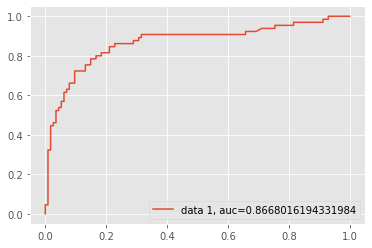

In [380]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Against Unseen Data

In [411]:
test3.columns

Index(['fare', 'sex_male', 'embarked_Q', 'embarked_S', 'pclass1_2',
       'pclass1_3', 'sibsp_dummy', 'parch_dummy', 'sibsp1_1', 'sibsp1_2',
       'sibsp1_3', 'sibsp1_4', 'sibsp1_5', 'sibsp1_8', 'parch1_1', 'parch1_2',
       'parch1_3', 'parch1_4', 'parch1_5', 'parch1_6', 'age_fillmean'],
      dtype='object')

In [412]:
#X_udf = test3.loc[:,['fare', 'sex_male', 'embarked_Q', 'embarked_S', 'pclass1_2',
#       'pclass1_3', 'sibsp_dummy', 'parch_dummy', 'age_fillmean']]

X_udf = test3.loc[:,['fare', 'sex_male', 'embarked_Q', 'embarked_S', 'pclass1_2',\
                  'pclass1_3', 'sibsp1_1', 'sibsp1_2', 'sibsp1_3', 'sibsp1_4', 'sibsp1_5',\
                  'sibsp1_8', 'parch1_1', 'parch1_2', 'parch1_3', 'parch1_4', 'parch1_5',\
                  'parch1_6', 'age_fillmean']]

X_u = X_udf.values

In [413]:
X_udf.loc[X_udf.fare.isna()]

,fare,sex_male,embarked_Q,embarked_S,pclass1_2,pclass1_3,sibsp1_1,sibsp1_2,sibsp1_3,sibsp1_4,sibsp1_5,sibsp1_8,parch1_1,parch1_2,parch1_3,parch1_4,parch1_5,parch1_6,age_fillmean


In [414]:
preds_u = logreg.predict(X_u)

In [415]:
preds_u_df = pd.DataFrame(preds_u)

In [420]:
preds_u_df.sum()

0    162
dtype: int64

# export

In [397]:
ts = time.time()

In [402]:
st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

In [405]:
preds_u_df.to_csv(path+'titanic_preds'+str(st)+'.csv')

# Decision Tree

This initial model arrives at around 76% accuracy on the unseen dataset. Let's try and improve this 

In [424]:
train2.loc[:,['fare', 'sex_male', 'embarked_Q', 'embarked_S', 'pclass1_2',
  'pclass1_3', 'sibsp_dummy', 'parch_dummy', 'age_fillmean']]

,fare,sex_male,embarked_Q,embarked_S,pclass1_2,pclass1_3,sibsp_dummy,parch_dummy,age_fillmean
0,7.2500,1,0,1,0,1,1.0,0.0,22.000000
1,71.2833,0,0,0,0,0,1.0,0.0,38.000000
2,7.9250,0,0,1,0,1,0.0,0.0,26.000000
3,53.1000,0,0,1,0,0,1.0,0.0,35.000000
4,8.0500,1,0,1,0,1,0.0,0.0,35.000000
...,...,...,...,...,...,...,...,...,...
886,13.0000,1,0,1,1,0,0.0,0.0,27.000000
887,30.0000,0,0,1,0,0,0.0,0.0,19.000000
888,23.4500,0,0,1,0,1,1.0,1.0,29.699118
889,30.0000,1,0,0,0,0,0.0,0.0,26.000000


In [428]:
dt = DecisionTreeClassifier()

In [429]:
np.mean(
    cross_val_score(dt, X, y, scoring='accuracy',
                    cv=StratifiedKFold(n_splits=3))
)

0.7564534231200898

In [438]:
dt.fit(X_train, y_train)

confusion_matrix(y_true=y_test, y_pred=dt.predict(X_test), normalize='true')

array([[0.81578947, 0.18421053],
       [0.18461538, 0.81538462]])

In [441]:
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  98
False Positives:  16
False Negatives:  16
True Positives:  49


In [443]:
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%:".format(Accuracy))

Accuracy 82.12%:


In [456]:
preds_dt = dt.predict(X_u)

In [457]:
preds_dt_df = pd.DataFrame(preds_dt_df)

In [458]:
preds_dt_df.sum()

0    162
dtype: int64

In [460]:
ts = time.time()

In [461]:
st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

In [462]:
preds_dt_df.to_csv(path+'titanic_preds'+str(st)+'.csv')

### Random Forest

In [466]:
rfc = RandomForestClassifier()

In [467]:
np.mean(
    cross_val_score(rfc, X, y, scoring='accuracy',
                    cv=StratifiedKFold(n_splits=3))
)

0.7845117845117845

In [468]:
rfc.fit(X_train, y_train)

confusion_matrix(y_true=y_test, y_pred=rfc.predict(X_test), normalize='true')

array([[0.85087719, 0.14912281],
       [0.26153846, 0.73846154]])

In [469]:
params = {
    'n_estimators': [50, 100, 150, 300],
    'max_depth': [1, 2, 4, 8, 20]
}

In [470]:
grid = GridSearchCV(rfc, params, scoring='accuracy', cv=KFold(n_splits=3))

In [471]:
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_s

In [473]:
grid.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [474]:
rfc_best = RandomForestClassifier(max_depth=8, n_estimators=50)
rfc_best.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [475]:
accuracy_score(y_true=y, y_pred=rfc_best.predict(X))

0.8787878787878788

In [479]:
preds_rfc = rfc.predict(X_u)

In [483]:
preds_rfc

140

In [476]:
confusion_matrix(y_true=y, y_pred=rfc_best.predict(X), normalize='true')

array([[0.96903461, 0.03096539],
       [0.26608187, 0.73391813]])

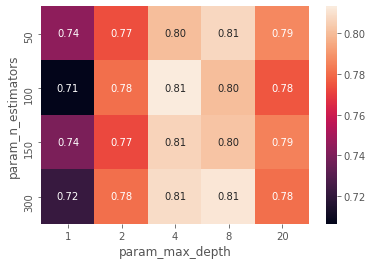

In [477]:
sns.heatmap(pd.DataFrame(grid.cv_results_).pivot_table(
    index='param_n_estimators',
    columns='param_max_depth',
    values='mean_test_score'
), annot=True, fmt='.2f')